<h2> Интернет-магазин «В один клик» <a class="tocSkip"> </h2>
Обучение с учителем: качество модели

Извините, проект не доделан - застрял на паплайне. Что с этим делать, не знаю - переыл весь интернет. Код раз за разом выдает ошибку, хотя он написан в соответствии с тем, что предлагался на уроке. Помогите, пожалуйста, понять, что с этим делать. 

### Введение

**Цель исследования**: Факторы активности покупателей в интернет-магазине «В один клик» 

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель исследования** - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Задачи:** 
1. Выполнить предобработку данных;
2. Отобрать наблюдения для построения модели;
3. Разработать модель, предсказывающую вероятность снижения покупательской активности;
4. Разработать рекомендации по повышению покупательской активности для одного из выделенных сегментов.

**Имеющиеся данные:** 
1. Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
2. Данные о выручке, которую получает магазин с покупателя;
3. Данные о времени, которое покупатель провёл на сайте в течение периода;
4. Данные о среднемесячной прибыли покупателя за последние 3 месяца.

### Загрузка данных

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.0 -q
!pip install matplotlib==3.5.1 -q
!pip install shap -q
!pip install phik -q

import shap
from sklearn.tree import export_text

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik 
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder

In [2]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=";", decimal=",")

In [3]:
data_gr = [market_file, market_money, market_time, money]
for d in data_gr:
    display(d.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [4]:
for d in data_gr:
    print(d.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Данные соответствуют описанию

### Предобработка данных

**Обработка названий переменных**

In [5]:
data_gr = [market_file, market_money, market_time, money]
for d in data_gr:
    print(d.columns)
    print()

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

Index(['id', 'Период', 'Выручка'], dtype='object')

Index(['id', 'Период', 'минут'], dtype='object')

Index(['id', 'Прибыль'], dtype='object')



In [6]:
market_file = market_file.rename(columns={
    'Покупательская активность': 'Покупательская_активность',
    'Тип сервиса': 'Тип_сервиса',
    'Разрешить сообщать': 'Разрешить_сообщать'
})
market_time = market_time.rename(columns={'минут': 'Минут'})

In [7]:
data_gr = [market_file, market_money, market_time, money]
for d in data_gr:
    print(d.columns)
    print()

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

Index(['id', 'Период', 'Выручка'], dtype='object')

Index(['id', 'Период', 'Минут'], dtype='object')

Index(['id', 'Прибыль'], dtype='object')



Названия переменных приведены к единообразию

**Проверка типов и пропусков данных**

In [8]:
data_gr = [market_file, market_money, market_time, money]
for d in data_gr:
    d.info()
    print('Число пропусков:')
    print(d.isnull().sum())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Типы данных верные, пропусков нет

**Оценка значений переменных**

In [9]:
data_gr = [market_file, market_money, market_time, money]
for d in data_gr:
    for c in d.select_dtypes(include=['object', 'category']).columns:
        print(c)
        print(d[c].unique())
        print()

Покупательская_активность
['Снизилась' 'Прежний уровень']

Тип_сервиса
['премиум' 'стандартт' 'стандарт']

Разрешить_сообщать
['да' 'нет']

Популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Период
['текущий_месяц' 'предыдцщий_месяц']



In [10]:
market_file.loc[market_file['Тип_сервиса'] == 'стандартт', 'Тип_сервиса'] = 'Стандарт'
market_file.loc[market_file['Тип_сервиса'] == 'стандарт', 'Тип_сервиса'] = 'Стандарт'
market_file.loc[market_file['Тип_сервиса'] == 'премиум', 'Тип_сервиса'] = 'Премиум'

market_file.loc[market_file['Разрешить_сообщать'] == 'да', 'Разрешить_сообщать'] = 'Да'
market_file.loc[market_file['Разрешить_сообщать'] == 'нет', 'Разрешить_сообщать'] = 'Нет'

market_file.loc[market_file['Популярная_категория'] == 'Косметика и аксесуары', 'Популярная_категория'] = (
    'Косметика и аксессуары')

market_money.loc[market_money['Период'] == 'препредыдущий_месяц', 'Период'] = 'Два месяца назад'
market_money.loc[market_money['Период'] == 'текущий_месяц', 'Период'] = 'Текущий месяц'
market_money.loc[market_money['Период'] == 'предыдущий_месяц', 'Период'] = 'Предыдущий месяц'

market_time.loc[market_time['Период'] == 'текущий_месяц', 'Период'] = 'Текущий месяц'
market_time.loc[market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'Предыдущий месяц'

In [11]:
data_gr = [market_file, market_money, market_time, money]
for d in data_gr:
    for c in d.select_dtypes(include=['object', 'category']).columns:
        print(c)
        print(d[c].unique())
        print()

Покупательская_активность
['Снизилась' 'Прежний уровень']

Тип_сервиса
['Премиум' 'Стандарт']

Разрешить_сообщать
['Да' 'Нет']

Популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Период
['Два месяца назад' 'Текущий месяц' 'Предыдущий месяц']

Период
['Текущий месяц' 'Предыдущий месяц']



Значения номинальных переменных приведены к единообразию, исправлены опечатки

**Оценка наличия дубликатов**

In [12]:
data_gr = [market_file, market_money, market_time, money]
for d in data_gr:
    print(d.duplicated().sum())

0
0
0
0


Дубликатов не обнаружено

### Исследовательский анализ данных

In [13]:
# функция для количественных непрерывных переменных
def graphic_quan_var(d, с):
    for q in с:
        plt.figure(figsize=(16, 4))
        plt.hist(d[q], bins=60)
        plt.title(f'Распределение значений переменной "{q}"')
        plt.xlabel('Значения')
        plt.ylabel('Частота')
        plt.figure(figsize=(16, 4))
        sns.boxplot(x=d[q])
        plt.title(f'Распределение вероятностей переменной "{q}"')
        plt.show()

# функция для количественных дискретных переменных
def d_graphic_quan_var(d, с):
    for q in с:
        plt.figure(figsize=(16, 4))
        d.pivot_table(index=q, values='id', aggfunc='count').plot(kind='bar', legend=None)
        plt.title(f'Распределение значений переменной "{q}"')
        plt.xlabel('Значения')
        plt.ylabel('Частота')
        plt.show()

# функция для категориальных переменных 
def graphic_nominal_var(d, с):
    for n in с:
        plt.figure(figsize=(16, 6))
        plt.pie(d[n].value_counts(),labels=d[n].unique(), autopct='%1.0f%%')
        plt.title(f'Распределение значений переменной "{n}"')
        plt.show()

#### market_file

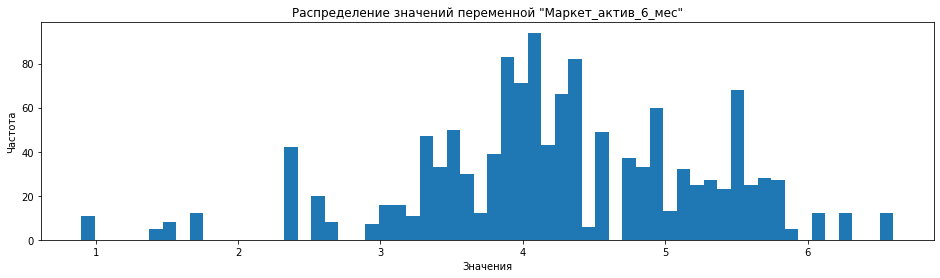

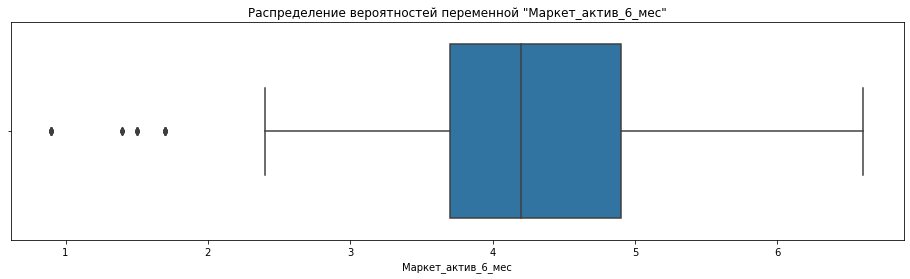

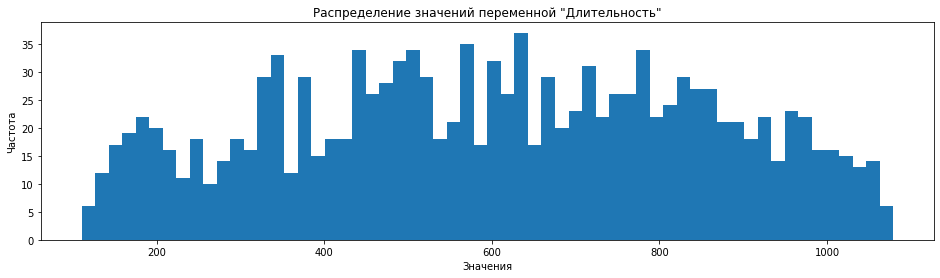

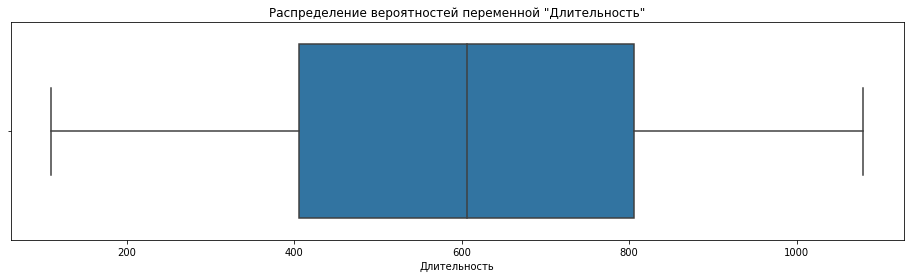

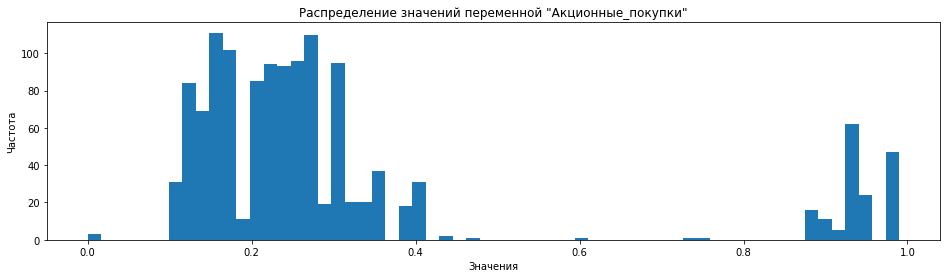

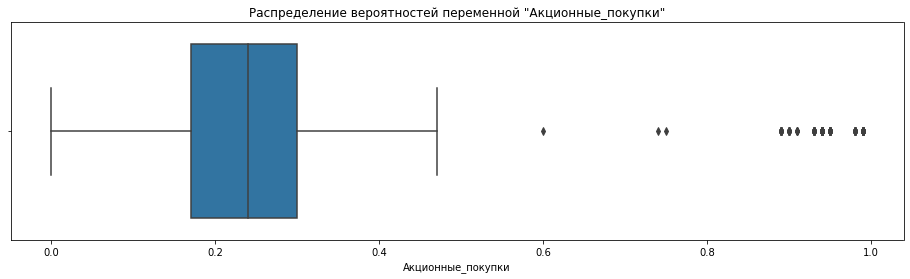

In [14]:
graphic_quan_var(market_file, ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки'])

<Figure size 1152x288 with 0 Axes>

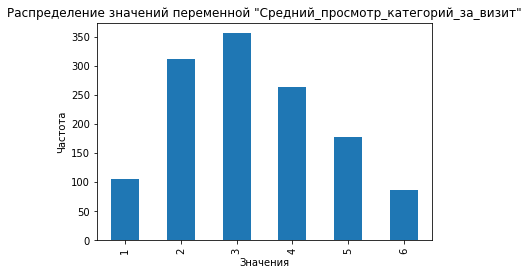

<Figure size 1152x288 with 0 Axes>

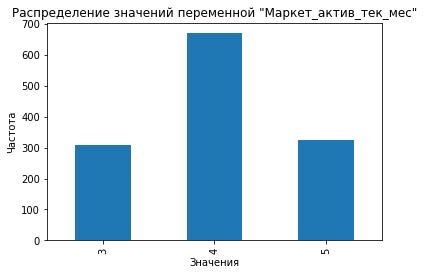

<Figure size 1152x288 with 0 Axes>

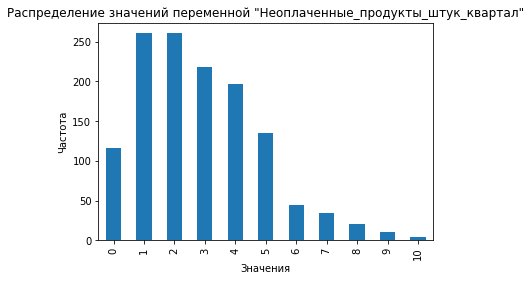

<Figure size 1152x288 with 0 Axes>

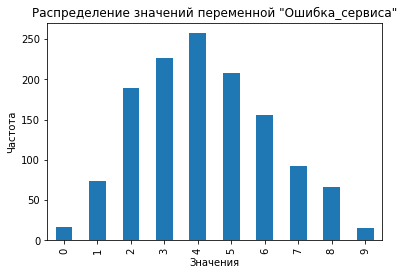

<Figure size 1152x288 with 0 Axes>

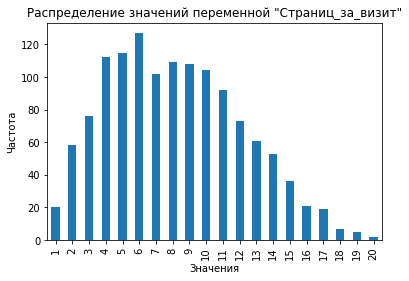

In [15]:
d_graphic_quan_var(market_file, ['Средний_просмотр_категорий_за_визит', 'Маркет_актив_тек_мес',
                                 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит'])

In [16]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


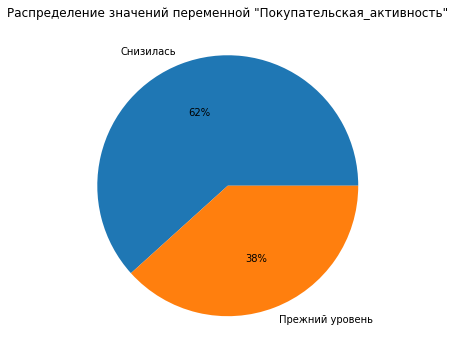

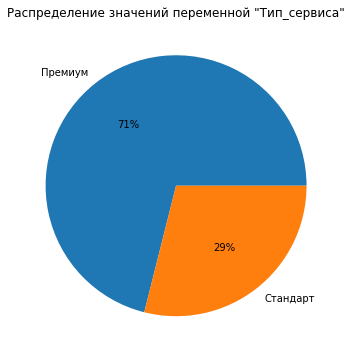

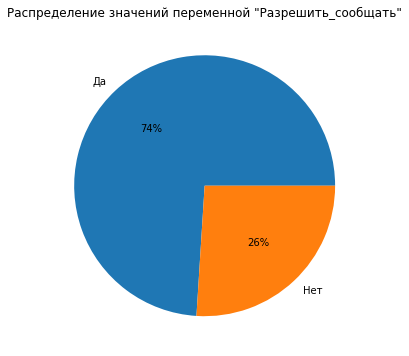

<Figure size 1152x288 with 0 Axes>

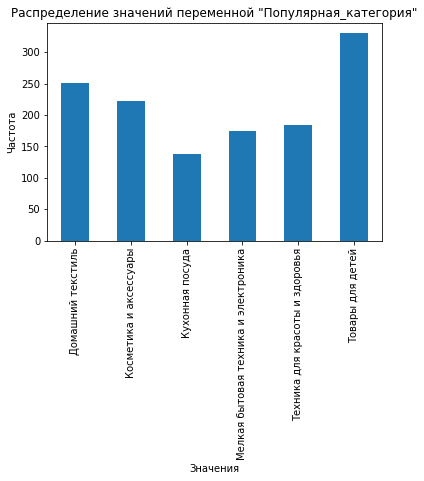

In [17]:
graphic_nominal_var(market_file, ['Покупательская_активность', 
                                  'Тип_сервиса', 'Разрешить_сообщать'])
d_graphic_quan_var(market_file, ['Популярная_категория'])

Не вижу причин удалять наблюдения из этого датасета.

Переменную 'Маркет_актив_тек_мес', видимо, всё-таки надо рассматривать как порядковую

#### market_money

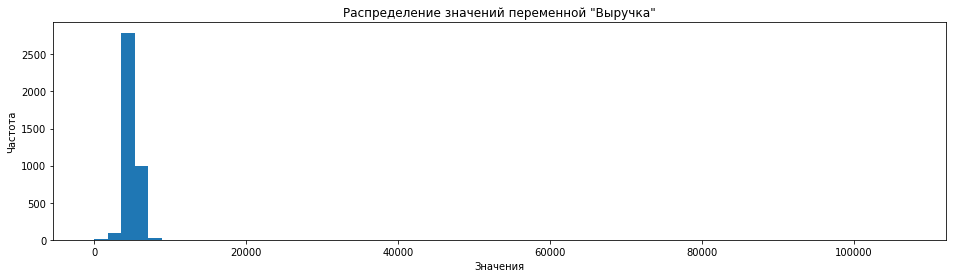

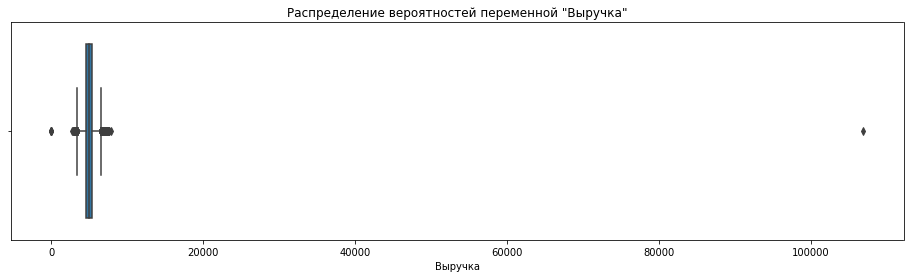

In [18]:
graphic_quan_var(market_money, ['Выручка'])

In [19]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


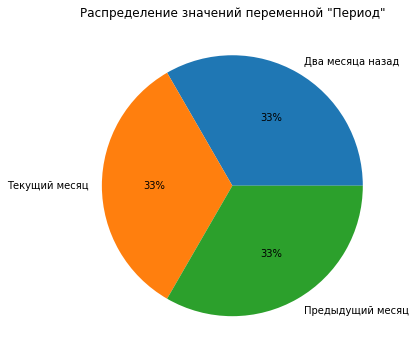

In [20]:
graphic_nominal_var(market_money, ['Период'])

106862.2 - явный выброс. Кроме того, удалим наблюдения с выручкой 0, чтобы выполнить условие по рассмотрению клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

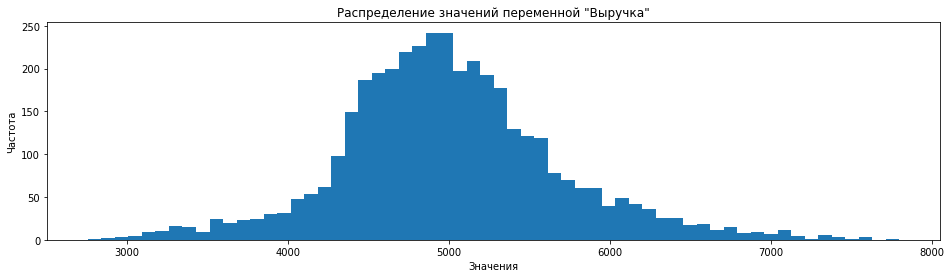

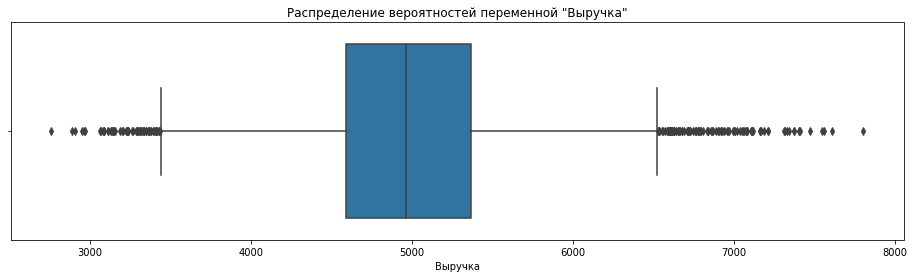

,id,Выручка
count,3893.000000,3893.000000
mean,215998.649371,5007.282918
std,374.681667,679.724898
min,215348.000000,2758.700000
25%,215674.000000,4592.000000
50%,215999.000000,4959.000000
75%,216323.000000,5363.000000
max,216647.000000,7799.400000


In [21]:
market_money = market_money[market_money['Выручка'] != 106862.2]
market_money = market_money[market_money['Выручка'] != 0]
graphic_quan_var(market_money, ['Выручка'])
market_money.describe()

#### market_time

<Figure size 1152x288 with 0 Axes>

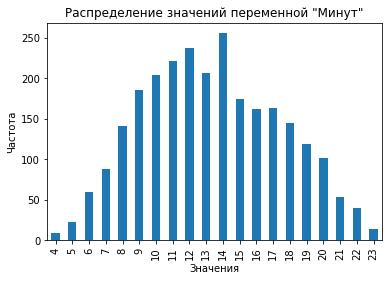

In [22]:
d_graphic_quan_var(market_time, ['Минут'])

In [23]:
market_time.describe()

,id,Минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


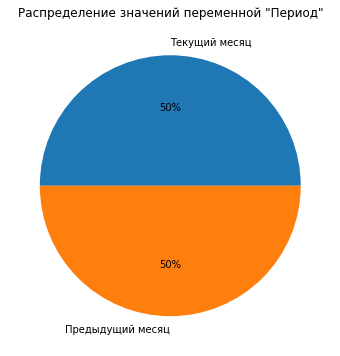

In [24]:
graphic_nominal_var(market_time, ['Период'])

Не вижу причин удалять наблюдения из датасета. 

#### money

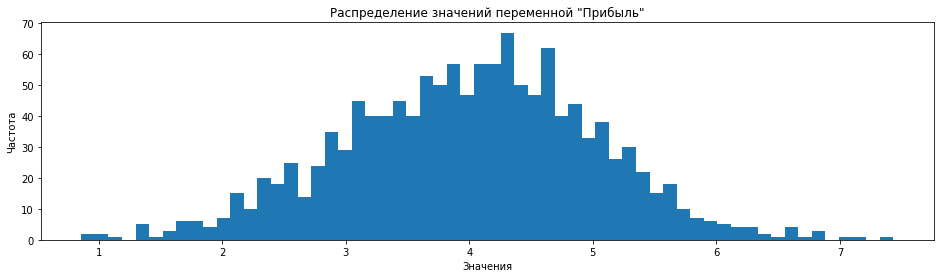

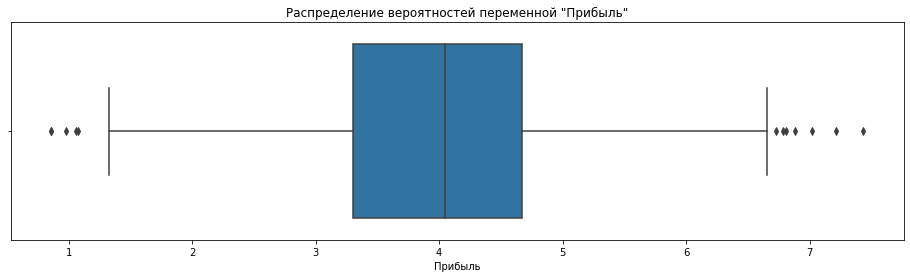

In [25]:
graphic_quan_var(money, ['Прибыль'])

In [26]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Не вижу причин удалять наблюдения из датасета. 

**По итогам прошлого отчетного периода у 62% клиентов снизилась покупательская активность.**

**Коммуникация с клиентом**
В датасете собраны данные о клиентах зарегистрировавшихся на сайте не менее 110 дней назад, самому "старому" клиенту в базе - 1079 дней (почти 3 года). 71% клиентов пользуются подпиской "премиум". 74% клиентов разрешили отправлять им дополнительные предложения о товаре. За прошлые шесть месяцев на одного клинта приходилось от 3 до 6 маркетинговых сообщений, в среднем - 4 сообщения. В этом месяце число маркетинговых коммуникаций на одного клиента не превышает 5. 

**Продуктовое поведение**
Наиболее популярная категория товаров среди клиентов - товары для детей, на втором месте - домашний текстиль, на третьем - косметика и аксессуары. У большинства клиентов доля акционных товаров в заказе составляет от 10% до 40%, но есть и существенная часть клиентов, доля акционных товаров в заказах которых превышает 85%. У большинства клиентов в корзине находится от 1 дло 5 неоплаченных товаров. 

**Поведение на сайте**
В среднем клиент проводит на сайте 13 минут. Чаще всего за один визит на сайт клиент просматривает от 2 до 4 категорий товаров. При этом за один визит клиент в среднем просматривает 8 страниц сайта. В датасете практически нет клиентов, которые не сталкивались с ошибками в работе сайта. 

**Финансовое поведение**
Каждый клиент в среднем ежемесячно обеспечивает магазину выруку в 5 тыс. у.е. (обычно от 4,6 до 5,4 тыс. у.е.) и 4 тыс. у.е. прибыли (обычно от 3,3 до 4,7 тыс. у.е.)

### Объединение таблиц

In [27]:
market_money['Период'].unique()

array(['Текущий месяц', 'Два месяца назад', 'Предыдущий месяц'],
      dtype=object)

In [28]:
market_money_tm = market_money.loc[market_money['Период'] == 'Текущий месяц']
market_money_pm = market_money.loc[market_money['Период'] == 'Предыдущий месяц']
market_money_2m = market_money.loc[market_money['Период'] == 'Два месяца назад']
market_time_tm = market_time.loc[market_time['Период'] == 'Текущий месяц']
market_time_pm = market_time.loc[market_time['Период'] == 'Предыдущий месяц']

In [29]:
market_money_tm = market_money_tm.drop(labels='Период', axis=1)
market_money_tm.columns = ['id', 'Выручка_текущий_месяц']

market_money_pm = market_money_pm.drop(labels='Период', axis=1)
market_money_pm.columns = ['id', 'Выручка_прошлый_месяц']

market_money_2m = market_money_2m.drop(labels='Период', axis=1)
market_money_2m.columns = ['id', 'Выручка_два_месяца_назад']

market_time_tm = market_time_tm.drop(labels='Период', axis=1)
market_time_tm.columns = ['id', 'Время_на_сайте_текущий_месяц']

market_time_pm = market_time_pm.drop(labels='Период', axis=1)
market_time_pm.columns = ['id', 'Время_на_сайте_прошлый_месяц']

In [30]:
data_all = money.merge(market_money_tm, on='id', how='left')
data_all = data_all.merge(market_money_pm, on='id', how='left')
data_all = data_all.merge(market_money_2m, on='id', how='left')
data_all = data_all.merge(market_time_tm, on='id', how='left')
data_all = data_all.merge(market_time_pm, on='id', how='left')
data_all = data_all.merge(market_file, on='id', how='left')

data_all

,id,Прибыль,Выручка_текущий_месяц,Выручка_прошлый_месяц,Выручка_два_месяца_назад,Время_на_сайте_текущий_месяц,Время_на_сайте_прошлый_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,0.98,3293.1,NaN,NaN,14,13,Снизилась,Премиум,Да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,4.16,4971.6,5216.0,4472.0,10,12,Снизилась,Премиум,Да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,3.13,5058.4,5457.5,4826.0,13,8,Снизилась,Стандарт,Нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,4.87,6610.4,6158.0,4793.0,13,11,Снизилась,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,4.21,5872.5,5807.5,4594.0,11,8,Снизилась,Стандарт,Нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,4.44,4741.7,3664.0,4704.0,7,14,Прежний уровень,Стандарт,Да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,6.11,5353.0,4729.0,5299.0,11,12,Прежний уровень,Стандарт,Нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,3.29,5139.2,5160.0,5334.0,18,12,Прежний уровень,Стандарт,Да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,4.03,5224.6,4923.0,4725.0,7,18,Прежний уровень,Стандарт,Да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


In [31]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Прибыль                              1300 non-null   float64
 2   Выручка_текущий_месяц                1299 non-null   float64
 3   Выручка_прошлый_месяц                1297 non-null   float64
 4   Выручка_два_месяца_назад             1297 non-null   float64
 5   Время_на_сайте_текущий_месяц         1300 non-null   int64  
 6   Время_на_сайте_прошлый_месяц         1300 non-null   int64  
 7   Покупательская_активность            1300 non-null   object 
 8   Тип_сервиса                          1300 non-null   object 
 9   Разрешить_сообщать                   1300 non-null   object 
 10  Маркет_актив_6_мес                   1300 non-null   float64
 11  Маркет_актив_тек_мес          

In [32]:
data_all = data_all.dropna()

In [33]:
data_all.shape

(1296, 19)

Создан общий массив данных. 

### Корреляционный анализ

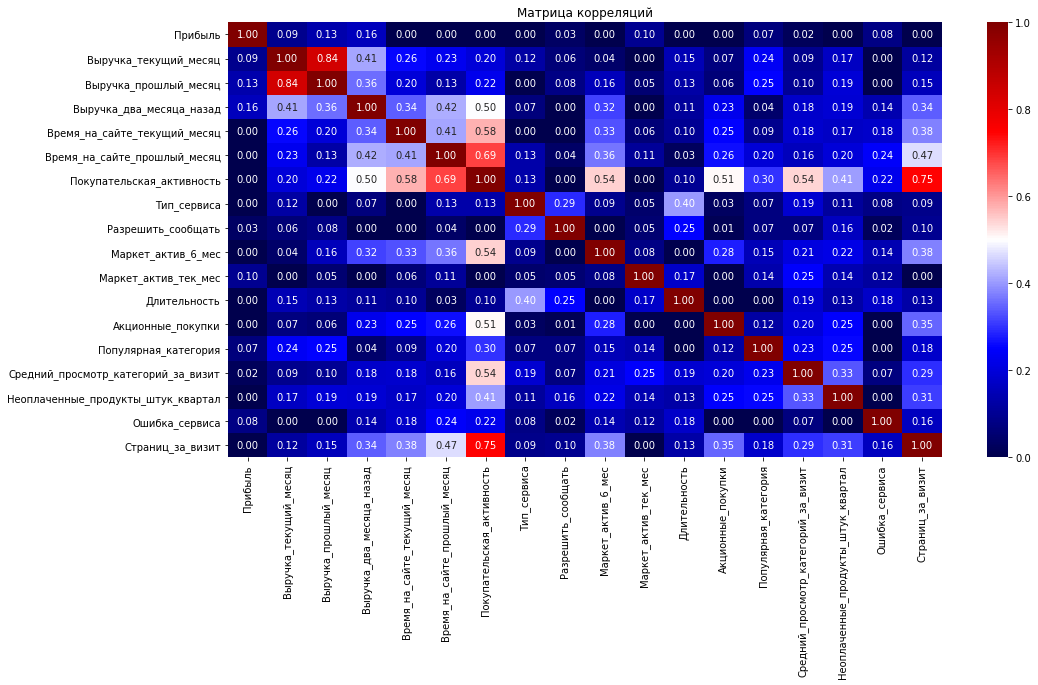

In [34]:
phik_matrix = data_all.drop('id', axis=1).phik_matrix(interval_cols=['Прибыль', 'Выручка_текущий_месяц', 
                                                                     'Выручка_прошлый_месяц', 
                                                                     'Выручка_два_месяца_назад', 
                                                                     'Время_на_сайте_текущий_месяц', 
                                                                     'Время_на_сайте_прошлый_месяц', 
                                                                     'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 
                                                                     'Длительность', 'Акционные_покупки'])
plt.figure(figsize=(16, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='seismic')
plt.title("Матрица корреляций")
plt.show()

Покупательская активность достаточно сильно связана с (1) числом страниц, посещаемым за вичит - 0,75, (2)временем, проведенным на сейте в текущем и прошлом месяце - 0, 69 и 0, 58 соответственно, (3) среднем числе просмотров категорий товаров за визит - о,54, (4) маркетинговой вктивностью за послшедние 6 месяцев, (5) долей покупаемых акционных товаров.

### Использование пайплайнов

In [35]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [36]:
data_all

,id,Прибыль,Выручка_текущий_месяц,Выручка_прошлый_месяц,Выручка_два_месяца_назад,Время_на_сайте_текущий_месяц,Время_на_сайте_прошлый_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,4.16,4971.6,5216.0,4472.0,10,12,Снизилась,Премиум,Да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,3.13,5058.4,5457.5,4826.0,13,8,Снизилась,Стандарт,Нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,4.87,6610.4,6158.0,4793.0,13,11,Снизилась,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,4.21,5872.5,5807.5,4594.0,11,8,Снизилась,Стандарт,Нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,3.95,5388.5,4738.5,5124.0,10,10,Снизилась,Стандарт,Да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,4.44,4741.7,3664.0,4704.0,7,14,Прежний уровень,Стандарт,Да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,6.11,5353.0,4729.0,5299.0,11,12,Прежний уровень,Стандарт,Нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,3.29,5139.2,5160.0,5334.0,18,12,Прежний уровень,Стандарт,Да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,4.03,5224.6,4923.0,4725.0,7,18,Прежний уровень,Стандарт,Да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


In [37]:
encoder = LabelEncoder()
data_all['Покупательская_активность_1'] = encoder.fit_transform(data_all['Покупательская_активность'])

/tmp/ipykernel_238/3154903999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['Покупательская_активность_1'] = encoder.fit_transform(data_all['Покупательская_активность'])


In [38]:
data_all

,id,Прибыль,Выручка_текущий_месяц,Выручка_прошлый_месяц,Выручка_два_месяца_назад,Время_на_сайте_текущий_месяц,Время_на_сайте_прошлый_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Покупательская_активность_1
1,215349,4.16,4971.6,5216.0,4472.0,10,12,Снизилась,Премиум,Да,4.4,4,819,0.75,Товары для детей,4,4,2,5,1
2,215350,3.13,5058.4,5457.5,4826.0,13,8,Снизилась,Стандарт,Нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,1
3,215351,4.87,6610.4,6158.0,4793.0,13,11,Снизилась,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4,1
4,215352,4.21,5872.5,5807.5,4594.0,11,8,Снизилась,Стандарт,Нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,1
5,215353,3.95,5388.5,4738.5,5124.0,10,10,Снизилась,Стандарт,Да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,4.44,4741.7,3664.0,4704.0,7,14,Прежний уровень,Стандарт,Да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,0
1296,216644,6.11,5353.0,4729.0,5299.0,11,12,Прежний уровень,Стандарт,Нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,0
1297,216645,3.29,5139.2,5160.0,5334.0,18,12,Прежний уровень,Стандарт,Да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,0
1298,216646,4.03,5224.6,4923.0,4725.0,7,18,Прежний уровень,Стандарт,Да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,0


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    data_all.drop(['id', 'Покупательская_активность', 'Покупательская_активность_1'], axis=1),
    data_all['Покупательская_активность_1'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_all['Покупательская_активность_1'])

In [40]:
ohe_columns = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']
ord_columns = ['Маркет_актив_тек_мес']
num_columns = ['Прибыль', 'Выручка_текущий_месяц', 'Выручка_прошлый_месяц', 
               'Выручка_два_месяца_назад', 'Время_на_сайте_текущий_месяц',
               'Время_на_сайте_прошлый_месяц', 'Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса', 'Страниц_за_визит']

In [ ]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first',  handle_unknown='ignore', sparse =False)
        )
    ]
) 

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[[3, 4, 5]], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='mean')
        )
    ]
) 


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 100),
        'models__max_features': range(2, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 200),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 200),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]

In [43]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions = param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [44]:
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['Тип_сервиса',
                                                                                'Разрешить_сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',...
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 100),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 100),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [45]:
print('Лучшая модель и её параметры:\n\n', randomized_search)
print ('Метрика ROC-AUC лучшей модели:', randomized_search.best_score_)
y_test_pred = randomized_search.predict_proba(X_test)[:,1] 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                         

В результате передора моделей наивысшее качество показало Дерево решений. Метрика ROC-AUC на тестовой выборке -  0.865

### Интерпретация модели

In [46]:
feature_importances = pd.DataFrame(
    {
        'Feature': pipe_final.named_steps['preprocessor'].fit(X_train).get_feature_names_out(),
        'Importance': randomized_search.best_estimator_.named_steps['models'].feature_importances_
    }) 

feature_importances = feature_importances.sort_values(by = 'Importance')

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

In [47]:
feature_importances

,Feature,Importance
0,ohe__Тип_сервиса_Стандарт,0.000000
1,ohe__Разрешить_сообщать_Нет,0.000000
2,ohe__Популярная_категория_Косметика и аксессуары,0.000000
3,ohe__Популярная_категория_Кухонная посуда,0.000000
4,ohe__Популярная_категория_Мелкая бытовая техни...,0.000000
5,ohe__Популярная_категория_Техника для красоты ...,0.000000
6,ohe__Популярная_категория_Товары для детей,0.000000
7,ord__Маркет_актив_тек_мес,0.000000
8,num__Прибыль,0.000000
9,num__Выручка_текущий_месяц,0.000000


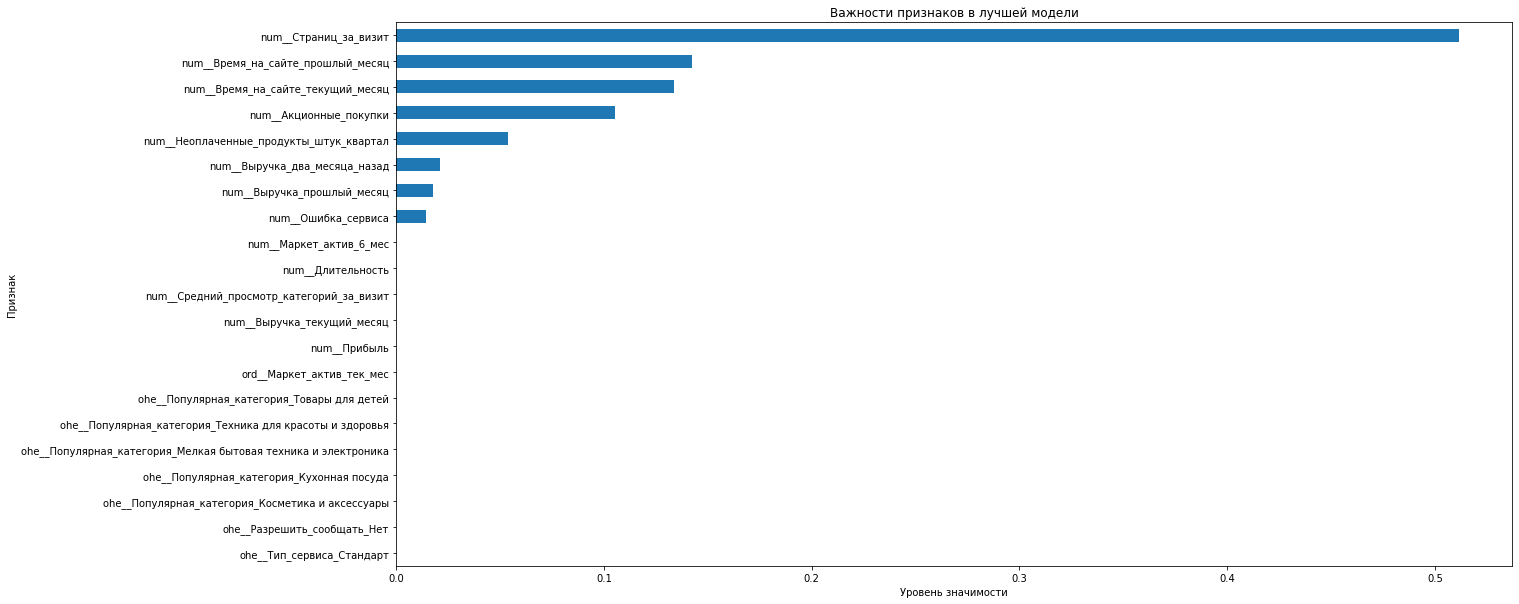

In [48]:
feature_importances.plot(kind = 'barh', x='Feature', y='Importance', legend=None, figsize=(20, 10))
plt.title('Важности признаков в лучшей модели')
plt.xlabel('Уровень значимости')
plt.ylabel('Признак')
plt.rcParams['font.size'] = 20
plt.show()

Чаще всего в модели Дерева решений использовалась переменная, отражающая число визитов посещаемых клиентов за один визит. Далее с большим отрывом следуют переменные времени, проведенного на сейте в текущем и прошлом месяце, доли покупаемых акционных товаров, числе неоплаченных товаров в корзине. 

In [49]:
text_representation = export_text(
    randomized_search.best_estimator_.named_steps['models'],
    feature_names=list(pipe_final.named_steps['preprocessor'].fit(X_train).get_feature_names_out()),
    max_depth=3
)
print(text_representation) 

|--- num__Страниц_за_визит <= 5.50
|   |--- num__Время_на_сайте_текущий_месяц <= 14.50
|   |   |--- num__Время_на_сайте_прошлый_месяц <= 15.50
|   |   |   |--- num__Выручка_два_месяца_назад <= 5068.50
|   |   |   |   |--- class: 1
|   |   |   |--- num__Выручка_два_месяца_назад >  5068.50
|   |   |   |   |--- class: 0
|   |   |--- num__Время_на_сайте_прошлый_месяц >  15.50
|   |   |   |--- num__Выручка_прошлый_месяц <= 5612.00
|   |   |   |   |--- class: 0
|   |   |   |--- num__Выручка_прошлый_месяц >  5612.00
|   |   |   |   |--- class: 1
|   |--- num__Время_на_сайте_текущий_месяц >  14.50
|   |   |--- num__Неоплаченные_продукты_штук_квартал <= 5.50
|   |   |   |--- num__Акционные_покупки <= 0.67
|   |   |   |   |--- class: 0
|   |   |   |--- num__Акционные_покупки >  0.67
|   |   |   |   |--- class: 1
|   |   |--- num__Неоплаченные_продукты_штук_квартал >  5.50
|   |   |   |--- class: 1
|--- num__Страниц_за_визит >  5.50
|   |--- num__Акционные_покупки <= 0.34
|   |   |--- num__Время_

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

В первую очередь модель делит клиентов по числу посещаемых страниц за один визит - на (1) тех, кто посещает 5 и более страниц, и (2) тех, кто посещает 4 и менее страниц. Именно этот критерий и будем использовать в сегментации. 

### Сегментация покупателей

In [50]:
def pages_visit(d):
    if d['Страниц_за_визит'] >=5:
        return '5 и более'
    return '4 и менее'

data_all['Страниц_за_визит_группы'] = data_all.apply(pages_visit, axis=1)
data_all['Страниц_за_визит_группы'].unique()

/tmp/ipykernel_238/1311188.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['Страниц_за_визит_группы'] = data_all.apply(pages_visit, axis=1)


array(['5 и более', '4 и менее'], dtype=object)

In [51]:
data_all.columns

Index(['id', 'Прибыль', 'Выручка_текущий_месяц', 'Выручка_прошлый_месяц',
       'Выручка_два_месяца_назад', 'Время_на_сайте_текущий_месяц',
       'Время_на_сайте_прошлый_месяц', 'Покупательская_активность',
       'Тип_сервиса', 'Разрешить_сообщать', 'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
       'Популярная_категория', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Покупательская_активность_1',
       'Страниц_за_визит_группы'],
      dtype='object')

In [52]:
lst = ['Тип_сервиса', 'Разрешить_сообщать','Маркет_актив_тек_мес',
       'Популярная_категория', 'Средний_просмотр_категорий_за_визит', 
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Покупательская_активность']
       
for i in lst:
    t = data_all.pivot_table(index=i, columns='Страниц_за_визит_группы', values='id', aggfunc='count')
    t['4 и менее'] = t['4 и менее']/t['4 и менее'].sum()*100
    t['5 и более'] = t['5 и более']/t['5 и более'].sum()*100
    t.columns = ['4 и менее', '5 и более']
    display(t)

,4 и менее,5 и более
Тип_сервиса,,
Премиум,26.792453,29.388943
Стандарт,73.207547,70.611057


,4 и менее,5 и более
Разрешить_сообщать,,
Да,72.830189,74.296799
Нет,27.169811,25.703201


,4 и менее,5 и более
Маркет_актив_тек_мес,,
3,22.264151,24.151309
4,50.566038,51.794374
5,27.169811,24.054316


,4 и менее,5 и более
Популярная_категория,,
Домашний текстиль,19.622642,19.204656
Косметика и аксессуары,19.622642,16.585839
Кухонная посуда,13.962264,9.796314
Мелкая бытовая техника и электроника,7.924528,14.839961
Техника для красоты и здоровья,9.811321,15.130941
Товары для детей,29.056604,24.442289


,4 и менее,5 и более
Средний_просмотр_категорий_за_визит,,
1,19.622642,5.237633
2,34.339623,21.435500
3,25.660377,27.740058
4,12.075472,22.308438
5,6.415094,15.518914
6,1.886792,7.759457


,4 и менее,5 и более
Неоплаченные_продукты_штук_квартал,,
0,7.169811,9.408341
1,10.188679,22.696411
2,16.981132,20.659554
3,16.603774,16.779825
4,11.698113,16.100873
5,13.584906,9.602328
6,10.188679,1.648885
7,6.037736,1.745878
8,3.773585,0.969932


,4 и менее,5 и более
Ошибка_сервиса,,
0,0.377358,1.551891
1,6.037736,5.528613
2,21.886792,12.706111
3,21.886792,16.294859
4,19.245283,19.786615
5,12.452830,16.973812
6,7.924528,13.094083
7,5.660377,7.468477
8,4.150943,5.334627


,4 и менее,5 и более
Покупательская_активность,,
Прежний уровень,15.471698,73.811833
Снизилась,84.528302,26.188167


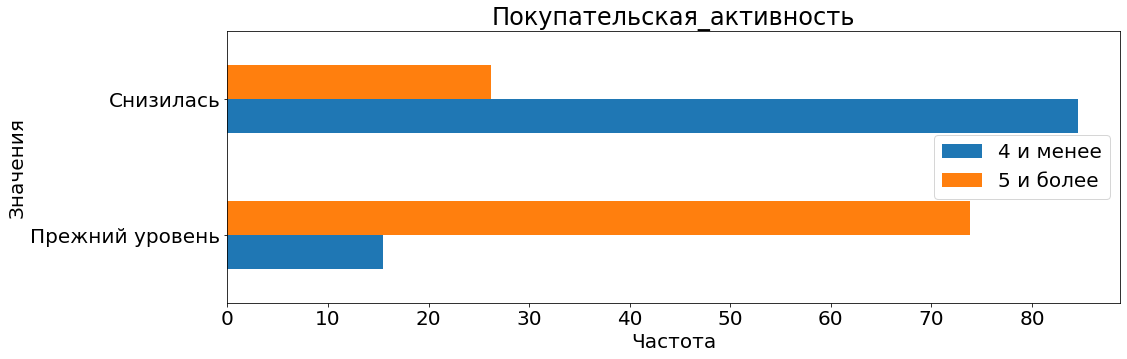

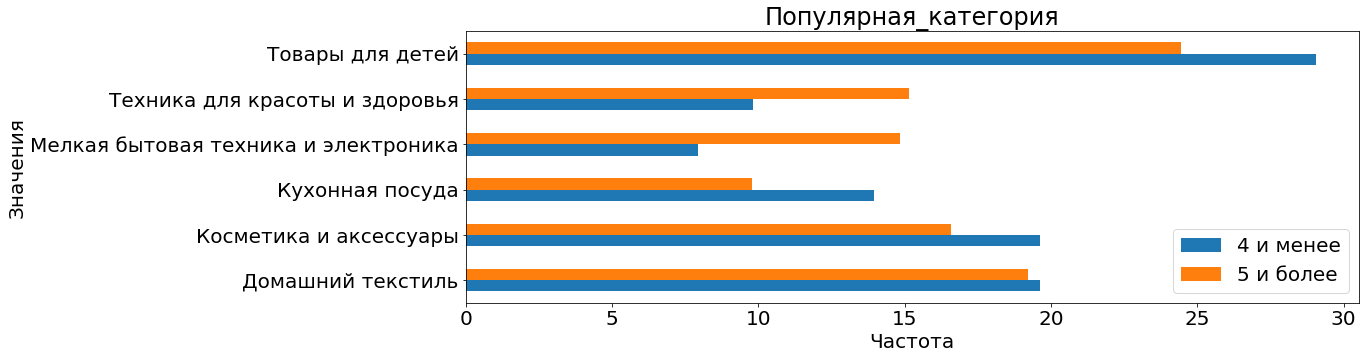

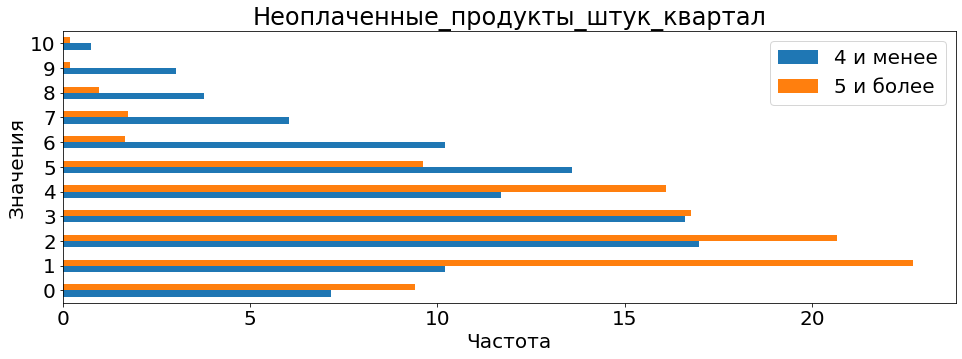

In [53]:
lst = ['Покупательская_активность', 'Популярная_категория', 'Неоплаченные_продукты_штук_квартал']
for i in lst:
    t = data_all.pivot_table(index=i, columns='Страниц_за_визит_группы', values='id', aggfunc='count')
    t['4 и менее'] = t['4 и менее']/t['4 и менее'].sum()*100
    t['5 и более'] = t['5 и более']/t['5 и более'].sum()*100
    t.columns = ['4 и менее', '5 и более']
    
    t.plot(kind = 'barh', figsize=(16, 5))
    plt.title(f'{i}')
    plt.xlabel('Частота')
    plt.ylabel('Значения')
    plt.show()

Итак, среди тех, кто посещает за визит 4 страницы и менее, доля снизивших покупательскую активность сильно выше - 85% против 26% среди тех, кто посещает 5 страниц за визит и более. 

Среди анализируемых переменных наиболее сильные отличия в сегментах демонстрируют "Популярная категория" и "Число неоплаченных продуктов в корзине". Так среди тех клиентов, которые посещают 4 страницы и менее, несколько более популярны товары для детей, кухонная посуда и косметика и аксессуары. А так же в их корзинах существенно больше неоплаченных товаров. 

В качестве стимулов, повышающих покупательскую активность можно рассмотреть (1) таргетированную акцию на товары для детей, кухонную посуду, косметику и аксессуары и (2) рассылку уведомлений о неоплаченных товаров в корзине. 

### ВЫВОД

Был произведен анализ данных о пользователях интернет магазина "В один клик", имеющих историю покупок не менее 3 месяцев. Предварительно была произведена предобработка - (1) пеобразованы названия переменных, (2) обработаны дубликаты, (3) удалены выбросы. Построена модель, предсказывающая снижение покупательской активности.

**РЕЗУЛЬТАТЫ ИССЛЕДОВАНИЯ**

**По итогам прошлого отчетного периода у 62% клиентов снизилась покупательская активность.**

Покупательская активность достаточно сильно связана с (1) числом страниц, посещаемым за визит - 0,75, (2)временем, проведенным на сейте в текущем и прошлом месяце - 0, 69 и 0, 58 соответственно, (3) среднем числе просмотров категорий товаров за визит - о,54, (4) маркетинговой вктивностью за послшедние 6 месяцев, (5) долей покупаемых акционных товаров. Как и ожидалось, в качестве ключевого фактора лучшая разработанная модель выделила число страниц, посещаемым за визит. В первую очередь модель делит клиентов по числу посещаемых страниц за один визит - на (1) тех, кто посещает 5 и более страниц, и (2) тех, кто посещает 4 и менее страниц.

Среди тех, кто посещает за визит 4 страницы и менее, доля снизивших покупательскую активность сильно выше - 85% против 26% среди тех, кто посещает 5 страниц за визит и более. Среди анализируемых переменных наиболее сильные отличия в сегментах демонстрируют "Популярная категория" и "Число неоплаченных продуктов в корзине". Так среди тех клиентов, которые посещают 4 страницы и менее, несколько более популярны товары для детей, кухонная посуда и косметика и аксессуары. А так же в их корзинах существенно больше неоплаченных товаров.

**РЕКОМЕНДАЦИИ**

В качестве стимулов, повышающих покупательскую активность можно рассмотреть (1) таргетированную акцию на товары для детей, кухонную посуду, косметику и аксессуары и (2) рассылку уведомлений о неоплаченных товаров в корзине.